In [19]:
# import data processing and visualisation libraries
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# import image processing libraries
import cv2
import skimage
from skimage.transform import resize

# import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
import os

print("Packages imported...")

Packages imported...


In [20]:
batch_size = 100
imageSize = 48
target_dims = (imageSize, imageSize, 3)
num_classes = 29

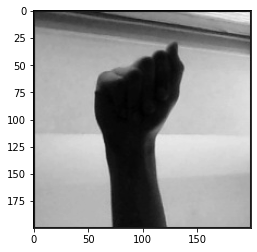

In [21]:
CATEGORIES = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z","del","nothing","space","0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "unknown"]
DATADIR = 'AI_SignLanguage-main/AI_SignLanguage-main/data/asl_alphabet_train/asl_alphabet_train/'

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)  # create path to categories
    for img in os.listdir(path):
      # iterate over each image
      # convert to array
      img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  
      plt.imshow(img_array, cmap='gray')  # graph it
      plt.show()  # display!

      break  # we just want one for now so break
    break  #...and one more!

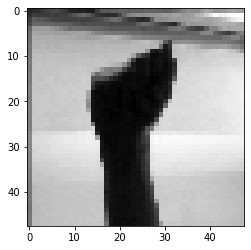

In [22]:
IMG_SIZE = 48

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show() # Show resize image

In [23]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do 0,1,2,3, .....

        path = os.path.join(DATADIR,category)  # create path to categories
        class_num = CATEGORIES.index(category)  # get the classification

        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            
create_training_data() # call function

100%|██████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 6175.23it/s]


In [32]:
import random
random.shuffle(training_data)

# Check
for sample in training_data[:10]:
    print(sample[1])

11
5
21
28
13
21
8
1
15
31


In [33]:
X = []
Y = []

for features,label in training_data:
    X.append(features)
    Y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

[[[[ 23]
   [ 18]
   [ 18]
   ...
   [ 25]
   [ 37]
   [ 55]]

  [[ 22]
   [ 16]
   [ 14]
   ...
   [ 50]
   [ 68]
   [ 59]]

  [[ 32]
   [ 32]
   [ 42]
   ...
   [ 60]
   [ 65]
   [ 64]]

  ...

  [[100]
   [157]
   [157]
   ...
   [233]
   [239]
   [240]]

  [[101]
   [154]
   [157]
   ...
   [235]
   [239]
   [242]]

  [[101]
   [159]
   [154]
   ...
   [238]
   [238]
   [244]]]]


In [34]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam # - Works

In [35]:
# number of possible label values
nb_classes = 40

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [36]:
#start training
from tensorflow.keras.callbacks import EarlyStopping
epochs = 50

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')


early_stop = EarlyStopping(monitor='val_loss',patience=2)
callbacks_list = [checkpoint,early_stop]

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=42,stratify=Y)

In [38]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [41]:
model.fit(X_train, y_train,
          epochs=30,
          batch_size=64,
          verbose=2,
          validation_data=(X_test, y_test),
          validation_split=0.3,
         callbacks=[callbacks_list])

Epoch 1/30
793/793 - 546s - loss: 0.1185 - accuracy: 0.9644 - val_loss: 0.0428 - val_accuracy: 0.9877 - 546s/epoch - 689ms/step
Epoch 2/30
793/793 - 569s - loss: 0.0988 - accuracy: 0.9693 - val_loss: 0.0364 - val_accuracy: 0.9901 - 569s/epoch - 718ms/step
Epoch 3/30
793/793 - 573s - loss: 0.0869 - accuracy: 0.9731 - val_loss: 0.0317 - val_accuracy: 0.9910 - 573s/epoch - 722ms/step
Epoch 4/30
793/793 - 570s - loss: 0.0752 - accuracy: 0.9769 - val_loss: 0.0337 - val_accuracy: 0.9898 - 570s/epoch - 719ms/step
Epoch 5/30
793/793 - 581s - loss: 0.0647 - accuracy: 0.9804 - val_loss: 0.0327 - val_accuracy: 0.9910 - 581s/epoch - 733ms/step


In [42]:
model.save('full.model')

INFO:tensorflow:Assets written to: full.model\assets
